In [2]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os
import sklearn.preprocessing

In [3]:
working_dir = os.getcwd()

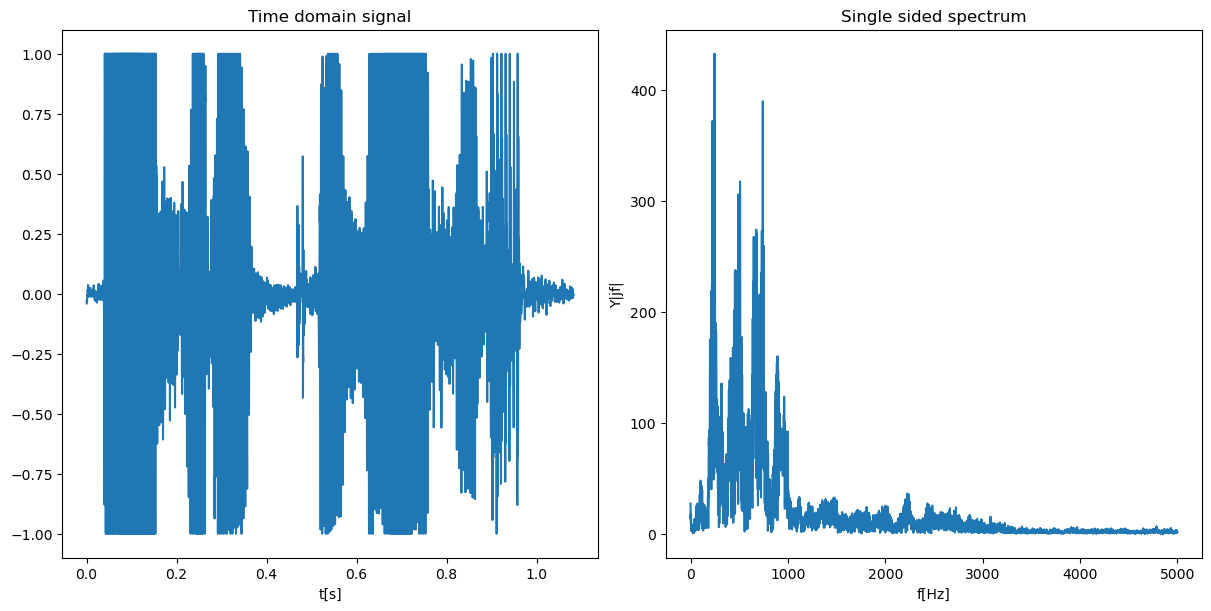

In [4]:
y, fs = librosa.load(os.path.join(working_dir, '..', 'Data', 'words', 'milica_sample', 'word_0.wav'), sr=None)
N = len(y)
duration = N/fs
t = np.linspace(0,duration,N)


Y = abs(np.fft.fft(y,N))
Y = Y[0:N//2]
f = np.fft.fftfreq(n = N, d = 1/fs)
f = f[0:N//2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t,y)
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[1].plot(f,Y)
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')

plt.show()

#### MFCC extraction using librosa

In [15]:
mfccs = librosa.feature.mfcc(y=y, sr=fs)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.shape)

(20, 22)


/home/mila/anaconda3/envs/speaker_rec/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/mila/anaconda3/envs/speaker_rec/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


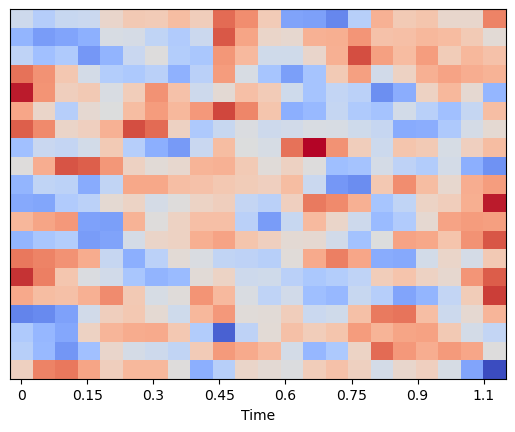

In [16]:
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

#### Extracting MFCCs manually
Instead of observing whole audio sinal, we will observe 30ms frames with overlap of 20ms.

In [24]:
window_length = int(30*10e-3*fs)
window_step = int(20*10e-3*fs) 

#### Windowing a signal
Most real world audio signals are non-periodic, however, the math of the Fourier transform assumes that the signal being transformed is periodic over the time span in question.
This mismatch between the Fourier assumption of periodicity, and the real world fact that audio signals are generally non-periodic, leads to "spectral leakage", and generally manifest as a wrongful distribution of energy across the power spectrum of the signal.
To reduce the effect of this we apply a tapered window function such as a Hann window which smooths out any such discontinuity

In [25]:
frames = librosa.util.frame(y, frame_length=window_length, hop_length=window_step)
frames.shape

(3000, 4)

In [26]:
windowed_frames = np.hanning(window_length).reshape(-1,1)*frames

Text(0.5, 0, 't[s]')

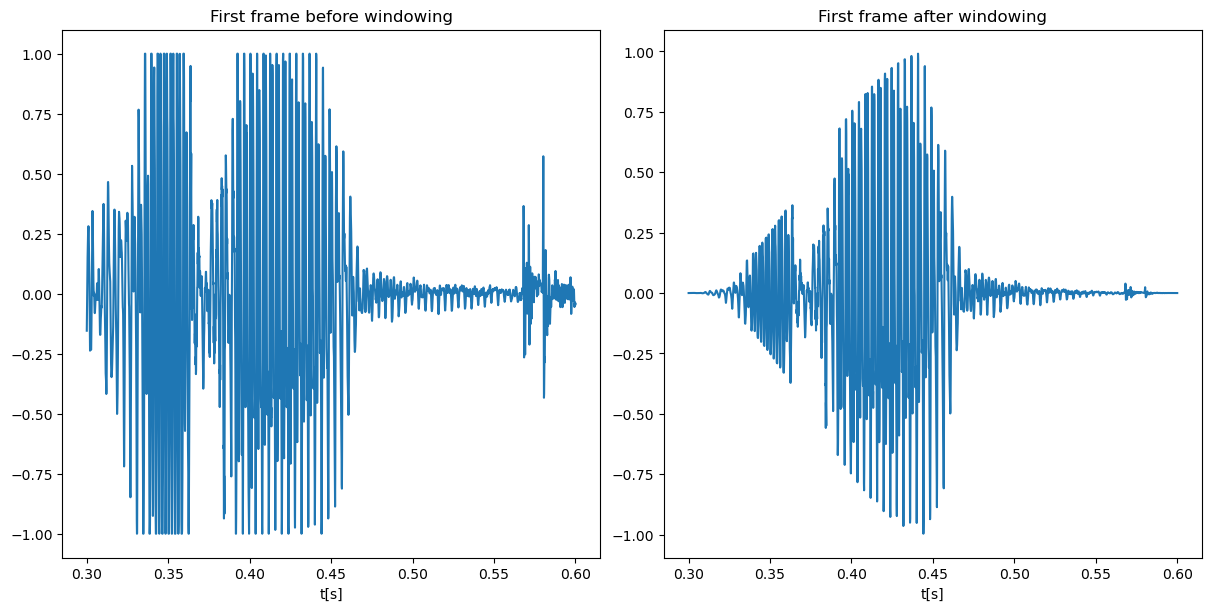

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t[window_length:2*window_length],frames[:,1])
axs[0].title.set_text('First frame before windowing')
axs[0].set_xlabel('t[s]')
axs[1].plot(t[window_length:2*window_length], windowed_frames[:,1])
axs[1].title.set_text('First frame after windowing')
axs[1].set_xlabel('t[s]')
plt.show()

##### Mel-frequency cepstrum
MFC is a representation of the short-term power spectrum. The difference of a cepstrum and MFC is that in the MFC the frequency bands are equally spaced on the mel scale, which approximates the human auditory system.